# EMA-BBP-RSI Strategy for Taiwnese Stock Market Day Trading

# Data Setup

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data_filepath = 'data/data.feather'
data_df = pd.read_feather(data_filepath)

In [3]:
bbands_length = 20
bbands_std = 2.5
ema_length = 200
ema_volumne_length = 20
rsi_length = 2

# Dictionary to collect computed results
results = {}

# Function to compute indicators for a given symbol
def compute_indicators(symbol):
    # Slice the dataframe once for the symbol
    df_symbol = data_df.xs(symbol, axis=1, level=1, drop_level=True)

    # Calculate returns
    adj_close = df_symbol['Adj Close']
    open_price = df_symbol['Open']
    close = df_symbol['Close']
    adj_open = (open_price / close) * adj_close
    rtns = 100 * (adj_close - adj_open) / adj_open
    targets = 100 * (adj_close - adj_close.shift(1)) / adj_close.shift(1)
    gap = 100 * (adj_open - adj_close.shift(1)) / adj_close.shift(1)
    
    # Compute TAs
    rsi= df_symbol.ta.rsi(length=rsi_length)
    results[(f'i_RSI_{rsi_length}', symbol)] = rsi
    
    ema = df_symbol.ta.ema(length=ema_length)
    results[(f'i_EMA_{ema_length}', symbol)] = ema

    bbands = df_symbol.ta.bbands(length=bbands_length, std=bbands_std)
    results[(f'i_BBP_{bbands_length}_{bbands_std}', symbol)] = bbands[f'BBP_{bbands_length}_{bbands_std}']

    ema_volume = df_symbol.ta.ema(close='Volume', length=ema_volumne_length)
    results[(f'i_EMA_Volume_{ema_volumne_length}', symbol)] = ema_volume

    # Update the results
    results[(f"returns", symbol)] = rtns
    results[(f"targets", symbol)] = targets
    results[(f"gap", symbol)] = gap

symbols = data_df.columns.get_level_values(1).unique()

for s in tqdm(symbols):
    compute_indicators(s)

  0%|          | 0/1796 [00:00<?, ?it/s]

In [4]:
# Concatenate the original DataFrame with the computed results
data_df = pd.concat([data_df, pd.DataFrame(results)], axis=1)

In [5]:
data_df.xs('6570.TWO', axis=1, level=1).columns  # Inspect the result

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'i_RSI_2',
       'i_EMA_200', 'i_BBP_20_2.5', 'i_EMA_Volume_20', 'returns', 'targets',
       'gap'],
      dtype='object')

In [6]:
data_df = data_df.iloc[-1260:]

# Trading Strategy

In [7]:
# Dictionary to collect computed results
results = {}

def gen_strategy_signals(symbol):
    df_symbol = data_df.xs(symbol, axis=1, level=1, drop_level=True)

    # Obtain the necessary series from df_symbol
    high = df_symbol['High']
    low = df_symbol['Low']
    ema = df_symbol['i_EMA_200']
    bbp = df_symbol['i_BBP_20_2.5']
    rsi = df_symbol['i_RSI_2']

    # Check for NaN values in any of the series
    nan_mask = high.isna() | low.isna() | ema.isna() | bbp.isna() | rsi.isna()

    # Initialize signal series with zeros
    signal_series = pd.Series(np.zeros(len(df_symbol)), index=df_symbol.index)

    # Evaluate long conditions
    long_conditions = (low > ema) & (bbp < 1) & (rsi < 30)
    signal_series = signal_series.where(~long_conditions, 1)

    # Evaluate short conditions
    short_conditions = (high < ema) & (bbp > 0) & (rsi > 50)
    signal_series = signal_series.where(~short_conditions, -1)  

    # Set signals to 0 where any NaN value is present
    signal_series[nan_mask] = 0

    # Update the results
    results[(f"signal", symbol)] = signal_series.shift(1)

# Proceed signal marking
symbols = data_df.columns.get_level_values(1).unique()

for s in tqdm(symbols):
    gen_strategy_signals(s)

  0%|          | 0/1796 [00:00<?, ?it/s]

In [8]:
# Concatenate the original DataFrame with the computed results
data_df = pd.concat([data_df, pd.DataFrame(results)], axis=1)

# Stock Selection

## Split and filter the data

In [9]:
def data_filtering(train, test, valid):
    train_close = train['Close']
    train_volume = train['Volume']
    symbols = train_close.columns
    
    symbols_to_remove = []
    
    for symbol in symbols:
        if train_close[symbol].isna().sum() > 252:
            symbols_to_remove.append(symbol)

    # filter the dfs
    filtered_train = train.drop(columns=symbols_to_remove, level=1)
    filtered_test = test.drop(columns=symbols_to_remove, level=1)
    filtered_valid = valid.drop(columns=symbols_to_remove, level=1)

    return filtered_train, filtered_test, filtered_valid 

# Split data_df into training and testing sets
train_size = int(len(data_df) * 0.8)
train_df = data_df.iloc[:train_size].copy()
test_df = data_df.iloc[train_size:].copy()

train_size = int(len(train_df) * 0.9)
valid_df = train_df.iloc[train_size:].copy()
train_df = train_df.iloc[:train_size].copy()

# Apply the data_filtering function
filtered_train_df, filtered_test_df, filtered_valid_df = data_filtering(train_df, test_df, valid_df)

## Refine the stock list

In [10]:
selected_symbols = filtered_train_df.columns.get_level_values(1).unique()
df_index = filtered_train_df.index

In [11]:
# Dictionary to store the results
stats_results = {}

for symbol in selected_symbols:
    # Extract features and target for the current stock
    stock_data = data_df.xs(symbol, axis=1, level=1).loc[df_index].copy()

    # Calculate mean and stdev
    long_df = stock_data.loc[stock_data['signal'] == 1, 'targets']
    mean_long = long_df.mean()
    stdev_long = long_df.std()
    
    short_df = stock_data.loc[stock_data['signal'] == -1, 'targets']
    mean_short = short_df.mean()
    stdev_short = short_df.std()

    avg_volume = stock_data.loc[stock_data.index[-1], f'i_EMA_Volume_{ema_volumne_length}'] / 1000
    
    # Store the results in the dictionary
    stats_results[symbol] = {
        'mean_long': mean_long,
        'stdev_long': stdev_long,
        'mean_short': mean_short,
        'stdev_short': stdev_short,
        'ratio_long': (mean_long / stdev_long) * avg_volume if len(long_df.index) >= 20 else np.nan,
        'ratio_short': (mean_short / stdev_short) * avg_volume if len(short_df.index) >= 20 else np.nan,
    }

# Convert the results dictionary to a DataFrame for better visualization
stats_df = pd.DataFrame(stats_results).T

# Backtest

## Apply stock selection

In [12]:
percentile_threshold = 90

long_ratio_values = [item['ratio_long'] for item in stats_results.values() if not np.isnan(item['ratio_long'])]
short_ratio_values = [item['ratio_short'] for item in stats_results.values() if not np.isnan(item['ratio_short'])]

top_percentile_long = np.percentile(long_ratio_values, percentile_threshold) if len(long_ratio_values) > 0 else np.nan
top_percentile_short = np.percentile(short_ratio_values, (100 - percentile_threshold)) if len(short_ratio_values) > 0 else np.nan

refined_selected_symbols = [s for s in selected_symbols \
                            if stats_results[s]['ratio_long'] > top_percentile_long or stats_results[s]['ratio_short'] < top_percentile_short]

print(f'Size of the refined selected symbols: {len(refined_selected_symbols)}')

Size of the refined selected symbols: 327


## Doing test

In [73]:
# The df use for the test
df = pd.concat([filtered_valid_df, filtered_test_df])

# Initial conditions and parameters
initial_capital = 1000000
equity = initial_capital
fund_available = equity
fund_available_list = []
equity_curve = [initial_capital]
return_list = []
pnl_list = []
positions = {}  # Dictionary to track current positions
commission_rate = 0.002  # 0.2%

total_trade_value = 0
total_trade_count = 0
position_value_list = []
position_share_list = []

In [74]:
import random

for date in tqdm(df.index):

    pnl = 0
    fund_available = equity_curve[-1]
    position_sizing = 0.3
    residual_position_sizing = 0.3

    # Randomize stock symbol list order
    random.shuffle(refined_selected_symbols)
        
    # Loop through each stock
    for symbol in refined_selected_symbols:        
        # Get a rolling window of 2 rows (current and previous row) for the current date
        stock_data = df.xs(symbol, axis=1, level=1).loc[date]
        
        if any(x is np.nan for x in [stock_data['Open'], stock_data['Close'], stock_data['Adj Close'], stock_data['signal']]):  # Check if data is available
            continue

        close = stock_data['Close']
        open = stock_data['Open']
        adj_close = close # stock_data['Adj Close']
        adj_open = open # open * adj_close / close
        action = stock_data['signal']

        volume = stock_data['Volume']
        
        # Execute action
        if abs(action) > 0:
            trade_filter = ( stock_data['gap'] < -2 ) if action == 1 else ( 2 < stock_data['gap'] )
            if trade_filter:        
                trade_side = action
                price = adj_open
                
                equity_adj = equity_curve[-1] / 1000  # 整張操作調整
                fund_available_adj = fund_available / 1000  # 整張操作調整
                
                num_shares = int(equity_adj * position_sizing * (1 - commission_rate) / price)
                num_shares_max = int(fund_available_adj * residual_position_sizing * (1 - commission_rate) / price)
                num_shares = num_shares_max if num_shares > num_shares_max else num_shares

                # 交易量擬真調整
                num_share_volume_upper_bound = int((volume / 1000) / 10)
                num_share_volume_upper_bound = max(1, num_share_volume_upper_bound) if volume > 2000 else num_share_volume_upper_bound
                if num_shares > num_share_volume_upper_bound:
                    # print(f'Symbol {symbol}: num_shares {num_shares}, upper_bound {num_share_volume_upper_bound}, volume {volume / 1000:.0f}')
                    num_shares = num_share_volume_upper_bound
                
                num_shares_adj = num_shares * 1000  # 整張操作調整
                
                if num_shares_adj > 0:
                    trade_value = num_shares_adj * price
                    total_trade_value += num_shares_adj * open
                    pnl -= trade_side * trade_value * (1 + trade_side * commission_rate)
                    fund_available -= trade_value * (1 + commission_rate)
                    positions[symbol] = {'action': action, 'num_shares': num_shares_adj, 'entry_date': date, 'entry_pruice': price}

                    position_value_list.append(num_shares_adj * open)
                    position_share_list.append(num_shares_adj)
        
        # Close position (if any)
        if symbol in positions:
            days_held = (date - positions[symbol]['entry_date']).days
            if days_held >= 0:
                trade_side = -1 if positions[symbol]['action'] == 1 else 1
                num_shares = positions[symbol]['num_shares']
                trade_value = num_shares * adj_close
                total_trade_value += num_shares * close
                pnl -= trade_side * trade_value * (1 + trade_side * commission_rate)
                del positions[symbol]  # Remove position
                total_trade_count += 1
                
    # Calculate equity and daily return
    equity = equity_curve[-1] + pnl
    daily_return = (equity - equity_curve[-1]) / equity_curve[-1]
    pnl_list.append(pnl)
    fund_available_list.append(fund_available)
    return_list.append(daily_return)
    equity_curve.append(equity)

  0%|          | 0/353 [00:00<?, ?it/s]

## Performance metrics and statistics

In [75]:
# Calculate performance metrics
final_equity = equity_curve[-1]
total_return = (final_equity - initial_capital) / initial_capital
annualized_return = (1 + total_return) ** (252 / len(df.index)) - 1
annualized_sharpe_ratio = np.sqrt(252) * np.mean(return_list) / np.std(return_list)
profit_factor = sum([x for x in pnl_list if x > 0]) / abs(sum([x for x in pnl_list if x < 0]))
win_day_ratio = 100 * len([x for x in pnl_list if x > 0]) / len(pnl_list)

# Print performance metrics
print(f"Period: {df.index[0].date()} - {df.index[-1].date()}, {len(df.index)} trading days")
print(f"Initial Equity: ${initial_capital:.0f}")
print(f"Final Equity: ${final_equity:.0f}")
print(f"Total Rate of Return: {total_return * 100:.2f}%")
print(f"Annualized Rate of Return: {annualized_return * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {annualized_sharpe_ratio:.2f}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Total Trade Count: {total_trade_count}")
print(f"Avg. Daily Trade Count: {total_trade_count / len(df.index) :.2f}")
print(f"Average PnL Percent: {100 * np.mean([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"Median PnL Percent: {100 * np.median([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"PnL Percent Stdev: {100 * np.std([p / e for p, e in zip(pnl_list, equity_curve[:-1])]):.2f}%")
print(f"Win Day Ratio: {win_day_ratio:.2f}%")

Period: 2022-05-04 - 2023-10-12, 353 trading days
Initial Equity: $1000000
Final Equity: $1600027
Total Rate of Return: 60.00%
Annualized Rate of Return: 39.87%
Annualized Sharpe Ratio: 2.02
Profit Factor: 1.44
Total Trade Count: 1068
Avg. Daily Trade Count: 3.03
Average PnL Percent: 0.14%
Median PnL Percent: 0.01%
PnL Percent Stdev: 1.10%
Win Day Ratio: 50.99%


In [76]:
monthly_trade_value = (total_trade_value / len(df.index)) * (252 / 12)

print(f"Monthly Average Trade Value: {monthly_trade_value:.2f}")
print(f"Monthly Turnover Ratio Est.: {monthly_trade_value / ((initial_capital+final_equity) / 2):.2f}")

Monthly Average Trade Value: 22291405.65
Monthly Turnover Ratio Est.: 17.15


In [77]:
print(f'Median Position Size: {np.median(position_value_list):.2f}')
print(f'Max Position Size: {np.max(position_value_list):.2f}')
print(f'Min Position Size: {np.min(position_value_list):.2f}')
print(f'Median Position Share: {np.median(position_share_list):.2f}')
print(f'Max Position Share: {np.max(position_share_list):.2f}')
print(f'Min Position Share: {np.min(position_share_list):.2f}')
print(f'Error Check: {np.sum([x % 1000 for x in position_share_list]):.2f}')

Median Position Size: 153400.00
Max Position Size: 499799.99
Min Position Size: 5990.00
Median Position Share: 3000.00
Max Position Share: 53000.00
Min Position Share: 1000.00
Error Check: 0.00


## Visualization

In [78]:
import yfinance as yf

# Load benchmark
index_df = yf.download(['0050.TW'], start=df.index[0], end=df.index[-1], progress=True)

[*********************100%%**********************]  1 of 1 completed


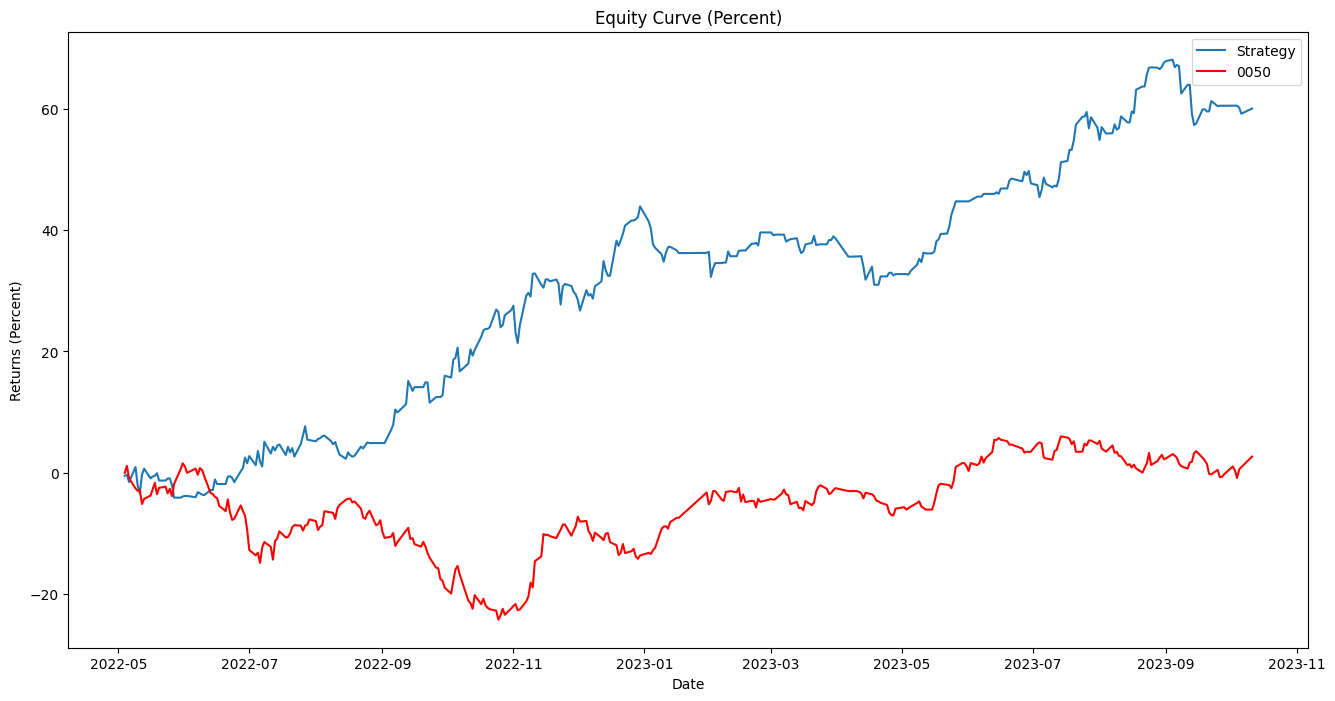

In [79]:
import matplotlib.pyplot as plt

# Plot equity curve
plt.figure(figsize=(16, 8))
plt.plot(df.index[:-1], [((x / initial_capital) - 1) * 100 for x in equity_curve[2:]], label="Strategy")
plt.plot(index_df.index, [x * 100 for x in (index_df['Adj Close'] / index_df['Adj Close'].iloc[0] - 1)], label="0050", color='red')
plt.title('Equity Curve (Percent)')
plt.xlabel('Date')
plt.ylabel('Returns (Percent)')
plt.legend()
plt.show()

In [20]:
# plt.figure(figsize=(16, 8))
# plt.plot(range(len(fund_available_list)), [a / b for a, b in zip(fund_available_list, equity_curve[:-1])])
# plt.show()

In [21]:
# plt.hist([a / b for a, b in zip(fund_available_list, equity_curve[:-1])], bins=50, edgecolor='k')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Data')
# plt.show()